Real inital desity n_i = 0.0123

Elapsed time 132.412038


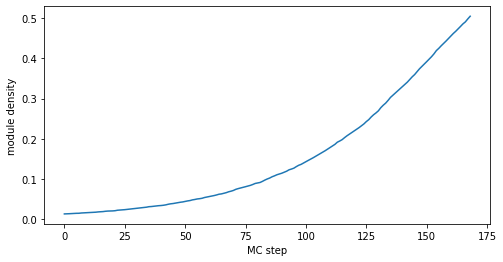

In [204]:
"""Simple Proximity Dynamics Model.

Model the network dynamics of solar panel installation
by assuming panel proximity as the main determining variable.

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

import pandas as pd
# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 300000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

# save some populations and densities 
# for visualizing and further analysis
densities = []

#----------------
# run simulation
#----------------
n_steps = 500
tStart = time()

tol = 1e-3


period = 10
radius = 2.0 / r0 * sqrt(scale)

radii = np.array([0.5, 1.0, 2.0, 4.0], dtype='float32') * sqrt(scale) / r0
intervals = np.array([1, 2, 3, 4], dtype='int8') # periods

generations = []
resultsl = []
results = []
results_scaled = []
new_indices = np.array([], dtype='int32')
last_indices = np.array([], dtype='int32')
countP = 0
for step in range(n_steps):
    
    countP += 1
    assigned = mc_step(locs, state)
    new_indices = np.concatenate((new_indices, assigned), axis=None)
    # new_panels = np.unique(new_panels)
    n = density(state)
    densities.append(n)
    if n > 0.5:
        break
    
    if countP >= period:
        
        table = np.zeros((radii.size, intervals.size))
        table_scaled = np.zeros((radii.size, intervals.size))
        new_panels = np.zeros(N, dtype='bool')
        new_panels[new_indices] = True
        
        for k, r in enumerate(radii):
            for j, p in enumerate(intervals):
                if p > len(generations): continue
                    
                last_indices = generations[-p]

                # for each last panel
                # calculate relative nb of new panels within A_r
                last_panels = np.zeros(N, dtype='bool')
                last_panels[last_indices] = True

                neighbourhood = all_dist < r
                helper = np.tile(new_panels, (N, 1))
                neighbourhood_panels = np.logical_and(helper, all_dist < r)

                n_neighbours = np.sum(neighbourhood, axis=1)[last_indices]
                n_panels = np.sum(neighbourhood_panels, axis=1)[last_indices]

                n_panels_rel = n_panels / n_neighbours
                avg = np.sum(n_panels_rel) / n_panels_rel.size
                
                table[k][j] = avg
                table_scaled[k][j] = avg / new_indices.size
        
        results.append(table)
        results_scaled.append(table_scaled)
        generations.append(new_indices)
        new_indices = np.array([], dtype='int32')
        countP = 0


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)

# output
fig = plt.figure(figsize=(8, 4))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()

df = pd.DataFrame()

In [205]:
mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results)):
    mean += results[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)


r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	3.374e-02 	3.358e-02 	3.318e-02 	3.285e-02 	
0.87 |	3.415e-02 	3.423e-02 	3.463e-02 	3.372e-02 	
1.74 |	3.455e-02 	3.442e-02 	3.438e-02 	3.371e-02 	
3.48 |	3.450e-02 	3.434e-02 	3.443e-02 	3.374e-02 	


In [207]:
mean = np.zeros((radii.size, intervals.size))

c = 0
for i in range(3, len(results_scaled)):
    mean += results_scaled[i]
    c += 1
                
mc = mean / c

print("")

header = "r/r0 |\t"
for i, inter in enumerate(intervals):
    header += "%d P \t \t" % inter

print(header)
print("")

for j, r in enumerate(radii):
    line = "%.2f |\t" % r
    for i, inter in enumerate(intervals):
        line += "%.3e \t" % mc[j, i]
    
    print(line)


r/r0 |	1 P 	 	2 P 	 	3 P 	 	4 P 	 	

0.43 |	1.049e-04 	1.020e-04 	1.011e-04 	9.525e-05 	
0.87 |	1.066e-04 	1.058e-04 	1.079e-04 	9.949e-05 	
1.74 |	1.064e-04 	1.062e-04 	1.065e-04 	9.918e-05 	
3.48 |	1.063e-04 	1.061e-04 	1.059e-04 	9.788e-05 	


Real inital desity n_i = 0.0130

268
0.466372679600867
891
0.3021774739621298
621
0.08351970524934221
158
0.02405577511807598
28
0.007719362947127419
6
0.0047619047619047615
1
0.0
Elapsed time 0.525993


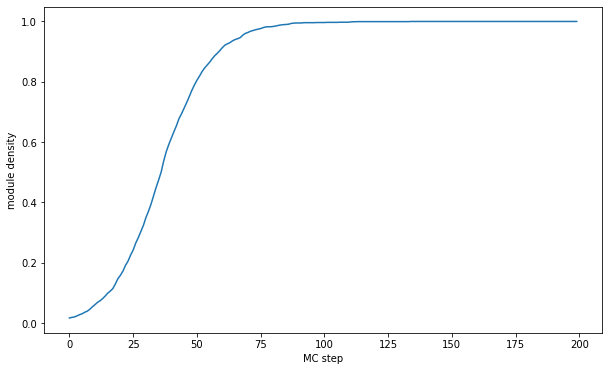

In [64]:
"""Simple Proximity Dynamics Model.

Model the network dynamics of solar panel installation
by assuming panel proximity as the main determining variable.

"""
from time import time

import numpy as np

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 300000
scale = 1.0 / 150
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    new_panels = []
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]
            if state[i]: 
                new_panels.append(i)
            
    return np.array(new_panels, dtype='int32')

# save some populations and densities 
# for visualizing and further analysis
densities = []

#----------------
# run simulation
#----------------
n_steps = 200
tStart = time()

tol = 1e-3


period = 20
radius = 2.0 / r0 * sqrt(scale)

new_indices = np.array([], dtype='int32')
last_indices = np.array([], dtype='int32')
countP = 0
for step in range(n_steps):
    
    countP += 1
    assigned = mc_step(locs, state)
    new_indices = np.concatenate((new_indices, assigned), axis=None)
    # new_panels = np.unique(new_panels)
    n = density(state)
    densities.append(n)
    
    if countP >= period:
        
        if last_indices.size > 0:
            # for each last panel
            # calculate relative nb of new panels within A_r
            last_panels = np.zeros(N, dtype='bool')
            last_panels[last_indices] = True
            new_panels = np.zeros(N, dtype='bool')
            new_panels[new_indices] = True
            neighbourhood = all_dist < radius
            helper = np.tile(new_panels, (N, 1))
            neighbourhood_panels = np.logical_and(helper, all_dist < radius)
            
            n_neighbours = np.sum(neighbourhood, axis=1)[last_indices]
            n_panels = np.sum(neighbourhood_panels, axis=1)[last_indices]
            
            n_panels_rel = n_panels / n_neighbours
            avg = np.sum(n_panels_rel) / n_panels_rel.size
            
            print(np.sum(last_panels))
            print(avg)
            #print(n_neighbours)
            #print(new_panels)
            
            
        last_indices = new_indices
        new_indices = np.array([], dtype='int32')
        countP = 0


elapsed = time() - tStart
print("Elapsed time %f" % elapsed)
    
fig = plt.figure(figsize=(10, 6))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()